# Face Recognition



In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


In [2]:
def faceRecoModel(input_shape):
    """
    Implementation of the Inception model used for FaceNet
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
        
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)
    
    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)

    # Second Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    # Inception 1: a/b/c
    X = inception_block_1a(X)
    X = inception_block_1b(X)
    X = inception_block_1c(X)
    
    # Inception 2: a/b
    X = inception_block_2a(X)
    X = inception_block_2b(X)
    
    # Inception 3: a/b
    X = inception_block_3a(X)
    X = inception_block_3b(X)
    
    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_first')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)
    
    # L2 normalization
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='FaceRecoModel')
        
    return model

In [3]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, here it is a dummy variable required by Keras
    y_pred -- python list containing three objects:
            anchor -- the embeddings for the anchor images, of shape (None, 128)
            positive -- the embeddings for the positive images, of shape (None, 128)
            negative -- the embeddings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
   
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)))
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)))

    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist), alpha)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
   
    
    return loss

In [5]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

In [6]:
load_weights_from_FaceNet(FRmodel)

In [8]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

X_train = X_train.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))
#Y_train = Y_train.transpose()
#Y_test = Y_test.transpose((0, 3, 1, 2))

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 426
number of test examples = 150
X_train shape: (426, 3, 96, 96)
Y_train shape: (426, 1)
X_test shape: (150, 3, 64, 64)
Y_test shape: (150, 1)


y = [b'felix']


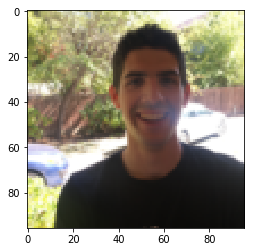

In [33]:
# Example of a picture
index = 12
plt.imshow(X_train.transpose((0,2,3,1))[index])
print ("y = " + str(Y_train[index, :]))

In [99]:
# Build database from X_train and Y_train
# database.shape = (m, 128)

m = X_train.shape[0]
database_emb = np.zeros((m, 128))
database_names = Y_train

for i in range(m):
    image = X_train[i,:,:,:]
    embedding = img1_to_embedding(image)
    database_emb[i,:] = embedding

In [105]:
#KNN on database with new image
new_emb = img_to_embedding("images/test_4.jpg")

(96, 96, 3)


In [ ]:
def img_to_embedding(image_path):
    img1 = cv2.imread(image_path, 1)
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = FRmodel.predict_on_batch(x_train)
    return embedding

In [59]:
def img1_to_embedding(img1):
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (0,1,2))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = FRmodel.predict_on_batch(x_train)
    return embedding

In [43]:
def verify(image_path, identity):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be a resident of the Happy house.
    X_train --
    Y_train --
    
    Returns:
    dist --
    door_open -- True, if the door should open. False otherwise.
    """
    
    # Compute the embedding for the image
    embedding = img_to_embedding(image_path)
    
    # Compute distance with identity's image
    dist = np.linalg.norm(database[identity] - embedding)
    
    if dist < 0.5:
        print("It's " + str(identity) + ", welcome home!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
        
    return dist, door_open

In [44]:
verify("images/test_4.jpg", "kian")

It's not kian, please go away


(0.56844276, False)

In [50]:
img1 = cv2.imread('images/test_a.jpg', 1)
img2 = cv2.imread('images/test_p.jpg', 1)
img3 = cv2.imread('images/test_n.jpg', 1)

In [51]:
# Read a sample image as input to test the model
img = img1[...,::-1]
img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
x_train = np.array([img])
y_a = FRmodel.predict_on_batch(x_train)
print (y_a)

[[ 0.00610059  0.11566171 -0.00177123 -0.090833    0.13567021  0.09768677
   0.01841084 -0.08207355 -0.11215911  0.05328089  0.07175611  0.02912529
   0.05609871  0.10683104  0.12721466 -0.00216605  0.05609728 -0.00599007
   0.0385747   0.11521572 -0.01536404  0.09386739 -0.02352911  0.04414971
  -0.03710434  0.03495996 -0.05916371  0.00561567  0.18412335  0.07763874
  -0.05576427  0.01676263  0.012035   -0.01562952  0.05462734  0.1523089
   0.0701123   0.05997399  0.04711723  0.01265215  0.02827886  0.05478783
  -0.03218067 -0.10073175 -0.1300763   0.1810675   0.12382702  0.03349272
  -0.15927674 -0.08743747 -0.12679778  0.04466631 -0.04483489 -0.00046972
   0.05468227  0.06561024 -0.09758288  0.15862644 -0.19626425  0.1000212
  -0.12070439  0.06497399  0.17567953 -0.15054919  0.11386677  0.12561136
   0.01864593  0.06938928 -0.09037534 -0.01233921  0.10075031  0.06063951
  -0.03548513 -0.00497482  0.14001766  0.10394157 -0.02689088  0.0444579
   0.07950066 -0.14740102  0.02691601  0.

In [48]:
# Read a sample image as input to test the model
img = img2[...,::-1]
img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
x_train = np.array([img])
y_p = FRmodel.predict_on_batch(x_train)
print (y_p)

[[ 0.01818656  0.02700492 -0.00859873 -0.1201554   0.10532109  0.13274175
   0.00348462  0.06485419 -0.12927984 -0.00593032  0.08673079  0.0156037
   0.10140105  0.1108925   0.15975112 -0.03096326  0.02508822 -0.10615048
   0.03048315  0.13826394  0.03051662  0.02462634  0.03731925  0.07380977
  -0.01428815 -0.0009637  -0.01613241 -0.02908552  0.17269117 -0.01726908
   0.02895273 -0.06105087 -0.00486803  0.02912608 -0.06070314  0.16051
   0.02219277  0.06831796  0.01741958  0.07973866  0.06959903  0.04030627
  -0.09389094 -0.07651751 -0.13772598  0.0353765   0.0910139   0.01779893
  -0.10743764 -0.04273626 -0.19518903 -0.01490634 -0.06164162  0.01628605
   0.00486952  0.07379046 -0.10000522  0.21943849 -0.17197922  0.04702061
  -0.16265158  0.084457    0.17762101 -0.16786881  0.06083988  0.17002273
   0.0677102   0.06299251 -0.0504337  -0.06641199  0.04205873  0.09809638
  -0.0501834   0.02378977  0.18221502  0.04516293 -0.00563662  0.02183324
   0.08732323 -0.02305888 -0.03903836  0.0

In [49]:
# Read a sample image as input to test the model
img = img3[...,::-1]
img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
x_train = np.array([img])
y_n = FRmodel.predict_on_batch(x_train)
print (y_n)

[[ 0.11937729  0.07323865  0.01832084 -0.04941032  0.10291766  0.22051692
   0.07864244  0.04084835 -0.04863924 -0.07544192  0.01157876  0.0437857
   0.13843454  0.05630936  0.04261133 -0.07641388  0.07106505 -0.0341705
  -0.11806607  0.15942946  0.08418394  0.10964416 -0.03362305  0.12332542
  -0.11529334 -0.11397544 -0.14995965 -0.0284775   0.04431283  0.10277456
  -0.04917568  0.0268299  -0.0511611   0.09545946 -0.0008268   0.09130361
   0.09032242  0.07778607 -0.08955834  0.00055231  0.0487622   0.05859488
  -0.05047186 -0.15166505 -0.09437975  0.04488001  0.06043364  0.03569184
  -0.09687302  0.07899421 -0.02211539 -0.00480432 -0.01112338  0.09145578
   0.12447556  0.03757088 -0.06776695  0.09468384 -0.07056082 -0.06510363
  -0.08751329  0.13012062  0.0826114  -0.26079461  0.01377799  0.0030481
   0.11417202  0.06938665 -0.14836164 -0.02459354  0.10340751  0.01556352
  -0.0134921  -0.01829056  0.05266656  0.15974827  0.01656939  0.00752547
   0.11104233 -0.01516755  0.02263657  0.

In [ ]:
diff_ap = np.linalg.norm(y_a - y_p)
diff_an = np.linalg.norm(y_a - y_n)
diff_pn = np.linalg.norm(y_n - y_p)
print(diff_ap, diff_an, diff_pn)

In [100]:
def who_is_it(image_path, database):
    
    # Compute the embedding for the image
    embedding = img_to_embedding(image_path)
    
    # Find the closest embedding
    closest = None
    min_dist = 100
    for (name, emb) in database.items():
        dist = np.linalg.norm(embedding - emb)
        print(dist, name)
        if dist < min_dist:
            min_dist = dist
            identity = name
            
    if min_dist > 0.6:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
    
    return min_dist, identity

In [101]:
who_is_it('images/test_5.jpg', database)

0.547473 sebastiano
0.495689 dan
0.53355 bertrand
0.605355 arnaud
0.637707 kian
0.68745 benoit
it's dan, the distance is 0.495689


(0.49568868, 'dan')

In [ ]:
FRmodel.fit(x = X_train, y = Y_train, epochs = 40, batch_size = 16)